Preparing necessary imports

In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from getpass import getpass
import omero.gateway as gw
import omero
import metrics.interface.omero as toolbox
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.interpolate import griddata
from tempfile import NamedTemporaryFile
import pandas as pd

from bokeh.io import output_file, show
from bokeh.layouts import gridplot
from bokeh.plotting import figure
from bokeh.models import ColorBar, LinearColorMapper


from credentials import *

### Defining display functions and a tag_to_function mapping

In [2]:
def print_map_ann(image):
    print(f'Measurements for image id: {image.getId()}\n{image.getName()}')
    for ann in image.listAnnotations():
        if ann.OMERO_TYPE == omero.model.MapAnnotationI and \
            ann.getNs().startswith('metrics'):
            print('Key: value')
            for m in ann.getValue():
                print(f'{m[0]}: {m[1]}')

def get_tables(omero_object, namespace_start='', name_filter=''):
    tables_list = list()
    resources = omero_object._conn.getSharedResources()
    for ann in omero_object.listAnnotations():
        if isinstance(ann, gw.FileAnnotationWrapper) and \
                ann.getNs().startswith(namespace_start) and \
                name_filter in ann.getFileName():
            table_file = omero_object._conn.getObject("OriginalFile", attributes={'name': ann.getFileName()})
            table = resources.openTable(table_file._obj)
            tables_list.append(table)

    return tables_list

def plot_homogeneity_map(image):
    nr_channels = image.getSizeC()
    x_dim = image.getSizeX()
    y_dim = image.getSizeY()

    tables = get_tables(image, namespace_start='metrics', name_filter='properties')
    if len(tables) != 1:
        raise Exception('There are none or more than one properties tables. Verify data integrity.')
    table = tables[0]

    row_count = table.getNumberOfRows()
    col_names = [c.name for c in table.getHeaders()]
    wanted_columns = ['channel',
                      'max_intensity',
                      'mean_intensity',
                      'integrated_intensity',
                      'x_weighted_centroid',
                      'y_weighted_centroid']

    fig, axes = plt.subplots(ncols=nr_channels, nrows=3, squeeze=False, figsize=(3 * nr_channels, 9))

    for c in range(nr_channels):
        data = table.slice([col_names.index(w_col) for w_col in wanted_columns],
                           table.getWhereList(condition=f'channel=={c}', variables={}, start=0, stop=row_count, step=0))
        max_intensity = np.array([val for col in data.columns for val in col.values if col.name == 'max_intensity'])
        integrated_intensity = np.array([val for col in data.columns for val in col.values if col.name == 'integrated_intensity'])
        x_positions = np.array([val for col in data.columns for val in col.values if col.name == 'x_weighted_centroid'])
        y_positions = np.array([val for col in data.columns for val in col.values if col.name == 'y_weighted_centroid'])
        grid_x, grid_y = np.mgrid[0:x_dim, 0:y_dim]
        image_intensities = toolbox.get_intensities(image, c_range=c, t_range=0).max(0)

        try:
            interpolated_max_int = griddata(np.stack((x_positions, y_positions), axis=1),
                                            max_intensity, (grid_x, grid_y), method='linear')
            interpolated_intgr_int = griddata(np.stack((x_positions, y_positions), axis=1),
                                              integrated_intensity, (grid_x, grid_y), method='linear')
        except Exception as e:
            # TODO: Log a warning
            interpolated_max_int = np.zeros((256, 256))

        ax = axes.ravel()
        ax[c] = plt.subplot(3, 4, c + 1)

        ax[c].imshow(np.squeeze(image_intensities), cmap='gray')
        ax[c].set_title('MIP_' + str(c))

        ax[c + nr_channels].imshow(np.flipud(interpolated_intgr_int),
                                   extent=(0, x_dim, y_dim, 0),
                                   origin='lower',
                                   cmap=cm.hot,
                                   vmin=np.amin(integrated_intensity),
                                   vmax=np.amax(integrated_intensity))
        ax[c + nr_channels].plot(x_positions, y_positions, 'k.', ms=2)
        ax[c + nr_channels].set_title('Integrated_int_' + str(c))

        ax[c + 2 * nr_channels].imshow(np.flipud(interpolated_max_int),
                                       extent=(0, x_dim, y_dim, 0),
                                       origin='lower',
                                       cmap=cm.hot,
                                       vmin=np.amin(image_intensities),
                                       vmax=np.amax(image_intensities))
        ax[c + 2 * nr_channels].plot(x_positions, y_positions, 'k.', ms=2)
        ax[c + 2 * nr_channels].set_title('Max_int_' + str(c))

    plt.show()

def plot_distances_map(image):
    nr_channels = image.getSizeC()
    x_dim = image.getSizeX()
    y_dim = image.getSizeY()

    tables = get_tables(image, namespace_start='metrics', name_filter='distances')
    if len(tables) != 1:
        raise Exception('There are none or more than one distances tables. Verify data integrity.')
    table = tables[0]
    row_count = table.getNumberOfRows()
    col_names = [c.name for c in table.getHeaders()]

    # We need the positions too
    pos_tables = get_tables(image, namespace_start='metrics', name_filter='properties')
    if len(tables) != 1:
        raise Exception('There are none or more than one positions tables. Verify data integrity.')
    pos_table = pos_tables[0]
    pos_row_count = pos_table.getNumberOfRows()
    pos_col_names = [c.name for c in pos_table.getHeaders()]

    fig, axes = plt.subplots(ncols=nr_channels - 1, nrows=nr_channels, squeeze=False, figsize=((nr_channels - 1) * 3, nr_channels * 3))

    ax_index = 0
    for ch_A in range(nr_channels):
        pos_data = pos_table.slice([pos_col_names.index(w_col) for w_col in ['channel',
                                                                             'mask_labels',
                                                                             'x_weighted_centroid',
                                                                             'y_weighted_centroid']],
                                   pos_table.getWhereList(condition=f'channel=={ch_A}', variables={}, start=0,
                                                          stop=pos_row_count, step=0))

        mask_labels = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'mask_labels'])
        x_positions = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'x_weighted_centroid'])
        y_positions = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'y_weighted_centroid'])
        positions_map = np.stack((x_positions, y_positions), axis=1)

        for ch_B in [i for i in range(nr_channels) if i != ch_A]:
            data = table.slice(list(range(len(col_names))),
                               table.getWhereList(condition=f'(channel_A=={ch_A})&(channel_B=={ch_B})', variables={}, start=0, stop=row_count, step=0))
            labels_map = np.array([val for col in data.columns for val in col.values if col.name == 'ch_A_roi_labels'])
            labels_map += 1  # Mask labels are augmented by one as 0 is background
            distances_map_3d = np.array([val for col in data.columns for val in col.values if col.name == 'distance_3d'])
            distances_map_x = np.array([val for col in data.columns for val in col.values if col.name == 'distance_x'])
            distances_map_y = np.array([val for col in data.columns for val in col.values if col.name == 'distance_y'])
            distances_map_z = np.array([val for col in data.columns for val in col.values if col.name == 'distance_z'])

            filtered_positions = positions_map[np.intersect1d(mask_labels, labels_map, assume_unique=True, return_indices=True)[1], :]

            grid_x, grid_y = np.mgrid[0:x_dim:1, 0:y_dim:1]
            interpolated = griddata(filtered_positions, distances_map_3d, (grid_x, grid_y), method='cubic')

            ax = axes.ravel()
            ax[ax_index].imshow(np.flipud(interpolated),
                                extent=(0, x_dim, y_dim, 0),
                                origin='lower',
                                cmap=cm.hot,
                                vmin=np.amin(distances_map_3d),
                                vmax=np.amax(distances_map_3d)
                                )
            ax[ax_index].set_title(f'Distance Ch{ch_A}-Ch{ch_B}')

            ax_index += 1

    plt.show()
    
def plot_distances_map_bokeh(image):
    nr_channels = image.getSizeC()
    x_dim = image.getSizeX()
    y_dim = image.getSizeY()

    tables = get_tables(image, namespace_start='metrics', name_filter='distances')
    if len(tables) != 1:
        raise Exception('There are none or more than one distances tables. Verify data integrity.')
    table = tables[0]
    row_count = table.getNumberOfRows()
    col_names = [c.name for c in table.getHeaders()]

    # We need the positions too
    pos_tables = get_tables(image, namespace_start='metrics', name_filter='properties')
    if len(tables) != 1:
        raise Exception('There are none or more than one positions tables. Verify data integrity.')
    pos_table = pos_tables[0]
    pos_row_count = pos_table.getNumberOfRows()
    pos_col_names = [c.name for c in pos_table.getHeaders()]

    # Prepare the plot
    plots = [[] for x in range(nr_channels)]
    # output_file("distances_map.html", title=f"Distances map for {image.getName()}\nAcquisition date: {image.getAcquisitionDate()}")
    color_mapper = LinearColorMapper(palette="Inferno256", low=0, high=1)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=10, location=(0, 0))

    for ch_A in range(nr_channels):
        pos_data = pos_table.slice([pos_col_names.index(w_col) for w_col in ['channel',
                                                                             'mask_labels',
                                                                             'x_weighted_centroid',
                                                                             'y_weighted_centroid']],
                                   pos_table.getWhereList(condition=f'channel=={ch_A}', variables={}, start=0,
                                                          stop=pos_row_count, step=0))

        mask_labels = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'mask_labels'])
        x_positions = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'x_weighted_centroid'])
        y_positions = np.array(
            [val for col in pos_data.columns for val in col.values if col.name == 'y_weighted_centroid'])
        positions_map = np.stack((x_positions, y_positions), axis=1)

        for ch_B in [i for i in range(nr_channels) if i != ch_A]:
            data = table.slice(list(range(len(col_names))),
                               table.getWhereList(condition=f'(channel_A=={ch_A})&(channel_B=={ch_B})', variables={}, start=0, stop=row_count, step=0))
            labels_map = np.array([val for col in data.columns for val in col.values if col.name == 'ch_A_roi_labels'])
            labels_map += 1  # Mask labels are augmented by one as 0 is background
            distances_map_3d = np.array([val for col in data.columns for val in col.values if col.name == 'distance_3d'])
            distances_map_x = np.array([val for col in data.columns for val in col.values if col.name == 'distance_x'])
            distances_map_y = np.array([val for col in data.columns for val in col.values if col.name == 'distance_y'])
            distances_map_z = np.array([val for col in data.columns for val in col.values if col.name == 'distance_z'])

            filtered_positions = positions_map[np.intersect1d(mask_labels, labels_map, assume_unique=True, return_indices=True)[1], :]

            grid_x, grid_y = np.mgrid[0:x_dim:1, 0:y_dim:1]
            interpolated = griddata(filtered_positions, distances_map_3d, (grid_x, grid_y), method='cubic')

            p = figure()
            p.title.text = f'Distance Ch{ch_A}-Ch{ch_B}'
            p.title.align = 'center'
            p.title.text_font_size = '18px'
            p.image(image=[interpolated],
                    x=0, y=0, dw=x_dim, dh=y_dim,
                    color_mapper=color_mapper)
            p.add_layout(color_bar, 'right')

            plots[ch_A].append(p)

    grid = gridplot(plots, plot_width=200 * (nr_channels - 1), sizing_mode='scale_both') #, plot_height=100 * nr_channels)

    show(grid)


def display_argoSIM_E(images):
    for image in images:
        print_map_ann(image)
        print('Some profiles should go in here')

def display_argoSIM_B(images):
    for image in images:
        print_map_ann(image)
        plot_homogeneity_map(image)
        plot_distances_map(image)
        plot_distances_map_bokeh(image)



tag_to_function = {'Argo-SIM_E_90deg': display_argoSIM_E,
                   'Argo-SIM_E_0deg': display_argoSIM_E,
                   'Argo-SIM_B': display_argoSIM_B}

### Open connection

In [3]:
conn = gw.BlitzGateway(username=USER,
                       passwd=PASSWORD,
                       host=HOST,
                       group=GROUP,
                       port=PORT)

# conn = gw.BlitzGateway(username=input('OMERO username:'), password=getpass('OMERO password:'),
#                        group=GROUP, host=OMERO_SERVER, port=PORT, secure=True)

conn.connect()
print(f'Connection successful: {conn.isConnected()}')

Connection successful: True


### Selecting the Microscope

In [4]:
microscopes = list(conn.getObjects('Project'))
micr_menu = widgets.Dropdown(options=[(m.getName(), i) for i, m in enumerate(microscopes)],
                     value=1,
                     description='Select a microscope:',
                     disabled=False,)
display(micr_menu)

Dropdown(description='Select a microscope:', index=1, options=(('microscope_2', 0), ('microscope_1', 1)), valu…

### Selecting the Dataset

In [5]:
microscope = microscopes[micr_menu.value]

datasets = list(microscope.listChildren())
dataset_menu = widgets.Dropdown(options=[(d.getName(), i) for i, d in enumerate(datasets)],
                     value=0,
                     description='Select a dataset:',
                     disabled=False,)
display(dataset_menu)

Dropdown(description='Select a dataset:', options=(('2017-02-20_monthly', 0), ('2017-02-20_yearly', 1), ('2017…

### Select the type of analysis to display

In [6]:
dataset = datasets[dataset_menu.value]
images = list(dataset.listChildren())

# Get the relevant tags associated to the images in the dataset
relevant_tags = ['Argo-SIM_B', 'AArgo-SIM_E_0deg', 'Argo-SIM_E_90deg', 'PSF beads']
present_tags = []

for image in images:
    for ann in image.listAnnotations():
        if ann.OMERO_TYPE == omero.model.TagAnnotationI and \
                ann.getTextValue() in relevant_tags and \
                ann.getTextValue() not in present_tags:
            present_tags.append(ann.getTextValue())

tags_menu = widgets.Dropdown(options=[tag for tag in present_tags],
                             description='Select an analysis type:',
                             disabled=False,)
display(tags_menu)

Dropdown(description='Select an analysis type:', options=('Argo-SIM_E_90deg', 'Argo-SIM_B', 'PSF beads'), valu…

### Run visualization

Measurements for image id: 3
201702_RI510_Argolight-1-1_010_SIR_ALX_THR.ome.tif
Key: value
Analysis_date_time: 2020-04-27 10:40:53.617626
Nr_of_spots_ch00: 64
Max_Intensity_ch00: 7689053.0
Max_Intensity_Roi_ch00: 7
Min_Intensity_ch00: 788494.0
Min_Intensity_Roi_ch00: 57
Min-Max_intensity_ratio_ch00: 0.10254760891880964
Nr_of_spots_ch01: 64
Max_Intensity_ch01: 6569755.0
Max_Intensity_Roi_ch01: 15
Min_Intensity_ch01: 514185.0
Min_Intensity_Roi_ch01: 61
Min-Max_intensity_ratio_ch01: 0.07826547565320167
Nr_of_spots_ch02: 64
Max_Intensity_ch02: 30716685.0
Max_Intensity_Roi_ch02: 22
Min_Intensity_ch02: 10982786.0
Min_Intensity_Roi_ch02: 63
Min-Max_intensity_ratio_ch02: 0.3575511485044692
Nr_of_spots_ch03: 64
Max_Intensity_ch03: 16789726.0
Max_Intensity_Roi_ch03: 14
Min_Intensity_ch03: 5119708.0
Min_Intensity_Roi_ch03: 63
Min-Max_intensity_ratio_ch03: 0.3049310036387729
Median_3d_dist_ch00_ch01: 0.7181108330452675
Median_z_dist_ch00_ch01: -1.8402709264571584
Median_3d_dist_ch00_ch02: 0.698098

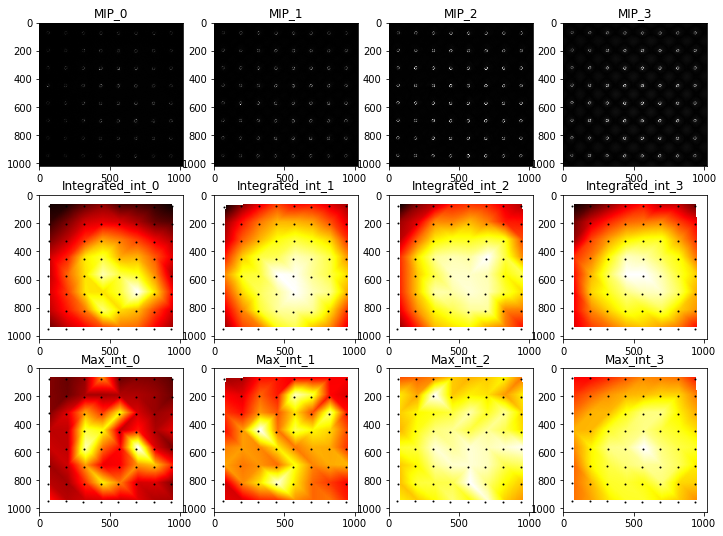

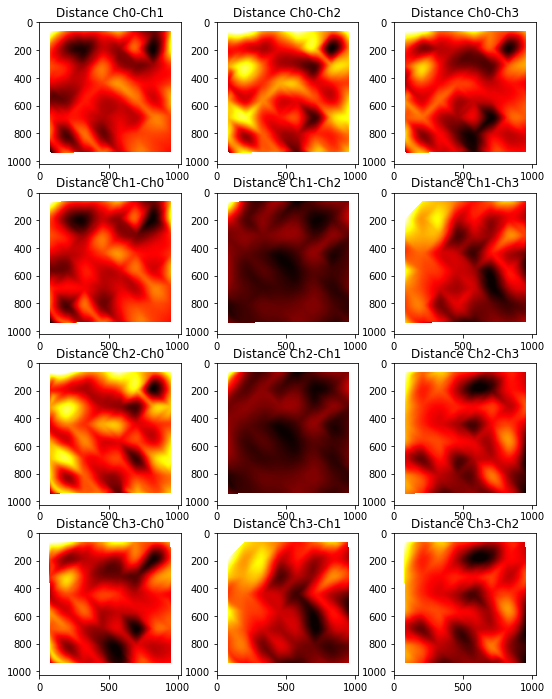

In [7]:
images_to_display = []

for image in images:
    for ann in image.listAnnotations():
        if ann.OMERO_TYPE == omero.model.TagAnnotationI and \
                ann.getTextValue() == tags_menu.value:
            images_to_display.append(image)

# table = plot_homogeneity_map(images_to_display[0])
tag_to_function[tags_menu.value](images_to_display)


In [21]:
# from tempfile import NamedTemporaryFile
# files_list = list()
# for ann in images_to_display[0].listAnnotations():
#     if isinstance(ann, gw.FileAnnotationWrapper) and \
#             ann.getNs().startswith('metrics') and \
#             'properties' in ann.getFileName():
#         with NamedTemporaryFile() as tf:
#             for chunk in ann.getFileInChunks():
#                 tf.write(chunk)
#             table_object = pd.read_hdf(tf.name)
#         files_list.append(table_object)
#
#


ValueError: No dataset in HDF5 file.